In [9]:
import pandas as pd
import numpy as np
import geopandas as gpd
import matplotlib.pyplot as plt
import seaborn as sns
from cenpy import products

In [59]:
stops = pd.read_csv('2019_Racial_Profiling__RP__Arrests.csv')

In [60]:
stops = stops.dropna(subset=['X_COORDINATE','Y_COORDINATE'])

In [61]:
stops = gpd.GeoDataFrame(
    data=stops,
    geometry=gpd.points_from_xy(
        x=stops['X_COORDINATE'],
        y=stops['Y_COORDINATE'],
        crs='ESRI:102739'
    )
)

<AxesSubplot:>

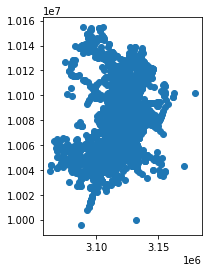

In [49]:
stops.plot()

In [10]:
acs_vars = {
    'B01003_001E':'total population',
    'B06011_001E':'median income'
}

acs = products.ACS(2019)

In [11]:
travis_tracts, travis  = acs.from_county('Travis County, TX',
                                         variables = list(acs_vars.keys()), 
                                         return_bounds=True,
                                         return_geometry=True)

/opt/anaconda3/envs/mapper2/lib/python3.7/site-packages/pyproj/crs/crs.py:53: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  return _prepare_from_string(" ".join(pjargs))


In [66]:
travis_tracts = travis_tracts.rename(columns=acs_vars)

<AxesSubplot:>

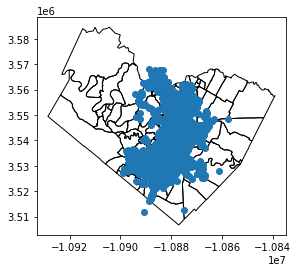

In [51]:
fig, ax = plt.subplots()

travis_tracts.plot(
    ax=ax,
    facecolor='none',
    edgecolor='k')

stops.to_crs(travis_tracts.crs).plot(ax=ax)

In [62]:
stops.to_crs(travis_tracts.crs, inplace=True)

In [94]:
stops_tracts = gpd.sjoin(
    stops, 
    travis_tracts
)

In [95]:
stops_by_tract = stops_tracts.groupby(
    'GEOID'
).agg(
    {'PRIMARY_KEY':'count', 
     'total population':'min'}
).rename(columns=
    {'PRIMARY_KEY':'stops'}
)

In [96]:
stops_by_tract['stops'].fillna(0, inplace=True)

In [111]:
stops_by_tract

,geometry,stops,total population,stop prevalence
GEOID,,,,
48453001779,"POLYGON ((-10913438.710 3557714.850, -10913435...",NaN,NaN,NaN
48453001778,"POLYGON ((-10907234.320 3550888.810, -10907174...",NaN,NaN,NaN
48453001740,"POLYGON ((-10894790.810 3528751.650, -10894759...",6.0,5017.0,0.001196
48453001729,"POLYGON ((-10891755.130 3528693.690, -10891525...",11.0,5075.0,0.002167
48453002423,"POLYGON ((-10889272.370 3525921.290, -10889122...",15.0,6007.0,0.002497
...,...,...,...,...
48453000306,"POLYGON ((-10877304.190 3542939.600, -10877297...",48.0,6029.0,0.007962
48453002201,"POLYGON ((-10872934.010 3545487.200, -10872900...",55.0,2223.0,0.024741
48453002319,"POLYGON ((-10870262.340 3529153.630, -10869731...",2.0,2368.0,0.000845


In [97]:
stops_by_tract['stop prevalence'] = stops_by_tract['stops'] / stops_by_tract['total population']

In [105]:
stops_by_tract['stop prevalence'] = stops_by_tract['stop prevalence'].replace(np.inf, np.nan)

In [98]:
stops_by_tract = travis_tracts.set_index('GEOID')[['geometry']].join(stops_by_tract)

<AxesSubplot:>

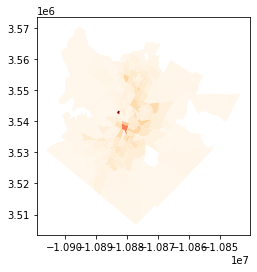

In [109]:
stops_by_tract.dropna().plot(
    column='stop prevalence',
    cmap='OrRd'
)

In [110]:
stops_by_tract.to_csv('stops_by_tract.csv')